Goal : Getting the diameter of an asteroid from the other data.

How : Supervised regression with the target being log(diameter)


Extra:  I will also remove columns with too high correlation for curiosity & added difficulty

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Only the first 50000 rows
df = pd.read_csv('Asteroid.csv',nrows = 30000)

In [3]:
df.head()

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,1 Ceres,2.769165,0.076009,0.12,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,...,9.074170,62.6284,0.713,0.426,NaN,C,G,N,N,1.59478
1,2 Pallas,2.772466,0.230337,0.11,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,...,7.813200,14.3000,0.635,0.284,NaN,B,B,N,N,1.23324
2,3 Juno,2.669150,0.256942,0.32,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,...,7.210000,NaN,0.824,0.433,NaN,Sk,S,N,N,1.03454
3,4 Vesta,2.361418,0.088721,0.32,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,...,5.342128,17.8000,0.782,0.492,NaN,V,V,N,N,1.13948
4,5 Astraea,2.574249,0.191095,NaN,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,...,16.806000,NaN,0.826,0.411,NaN,S,S,N,N,1.09589


There are lots of columns and things to check:
I wanted to know if there are NaN values ( there are, we'll deal about it later)

In [4]:
for column in df.columns:
    print(column, df[column].isnull().values.any())

full_name False
a False
e False
G True
i False
om False
w False
q False
ad False
per_y False
data_arc False
condition_code False
n_obs_used False
H False
diameter True
extent True
albedo True
rot_per True
GM True
BV True
UB True
IR True
spec_B True
spec_T True
neo False
pha False
moid False


Next thing is to understand what type of data we're dealing with

In [5]:
for column in df.columns:
    print(column, df[column].unique()[:10])

full_name ['     1 Ceres' '     2 Pallas' '     3 Juno' '     4 Vesta'
 '     5 Astraea' '     6 Hebe' '     7 Iris' '     8 Flora'
 '     9 Metis' '    10 Hygiea']
a [2.76916515 2.77246592 2.66914952 2.3614179  2.57424892 2.42515999
 2.38533381 2.20176419 2.38563654 3.14153918]
e [0.07600903 0.23033682 0.25694232 0.08872146 0.19109452 0.20300711
 0.23120579 0.15649925 0.12311427 0.11246066]
G [0.12 0.11 0.32  nan 0.24 0.28 0.17 0.22 0.23 0.2 ]
i [10.59406704 34.83623442 12.98891913  7.14177081  5.36698794 14.7379011
  5.52365139  5.88695456  5.57681551  3.83156003]
om [ 80.30553157 173.08006275 169.85275981 103.81080443 141.57660421
 138.64020276 259.56323069 110.88932989  68.9085767  283.20216686]
w [ 73.59769412 310.04885743 248.13862618 150.72854129 358.68760779
 239.80749023 145.26510583 285.28746222   6.41736923 312.31520625]
q [2.5586836  2.13386493 1.98333205 2.15190945 2.08232406 1.93283527
 1.83383082 1.85718974 2.09193063 2.78823962]
ad [2.97964671 3.41106691 3.35496699 2.57

Cleaning and prepping the dataframe:

0/ IR is full of nans so I will drop it

0bis/ I will drop full name too as I dont believe asteroids are named according to their diameter

1/ Dropping condition_code because most seems to be 0

2/ spec_B and spec_T might be interesting but I choose to drop them because we already have a lot to deal with

3/ will transform neo and pha Y,N to True,False

4/ diameter is string type, I will convert to numeric. Since the goal is to guess diameter, i will also drop all rows with a nan diameter.

5/ extent is also string type but 3d_types, since I suspect its the asteroid dimentions I will drop it

6/ finally replace nans with mean value of column

In [6]:
#Step 1
df = df.drop('condition_code',axis=1)

In [7]:
#Step 4
df['diameter']=pd.to_numeric(df['diameter'],errors='coerce') #transforming to numeric, setting errors to NaN
dropindexes = df['diameter'][df['diameter'].isnull()].index #rows with nan diameters to drop
dropped_df = df.loc[dropindexes] #saving dropped rows for the future
df = df.drop(dropindexes, axis=0) 

In [8]:
#Step 0,2,5
df = df.drop(['full_name','IR','spec_B','spec_T','extent'],axis=1)

In [9]:
#Step 3
df = df.replace({'neo': {'Y': True, 'N': False}})
df = df.replace({'pha': {'Y': True, 'N': False}})

In [10]:
#Step 6
df = df.fillna(df.mean())


df.head()

,a,e,G,i,om,w,q,ad,per_y,data_arc,...,H,diameter,albedo,rot_per,GM,BV,UB,neo,pha,moid
0,2.769165,0.076009,0.120000,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822,...,3.34,939.400,0.0900,9.074170,62.62840,0.713,0.426,False,False,1.59478
1,2.772466,0.230337,0.110000,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318,...,4.13,545.000,0.1010,7.813200,14.30000,0.635,0.284,False,False,1.23324
2,2.669150,0.256942,0.320000,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684,...,5.33,246.596,0.2140,7.210000,9.81609,0.824,0.433,False,False,1.03454
3,2.361418,0.088721,0.320000,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288,...,3.20,525.400,0.4228,5.342128,17.80000,0.782,0.492,False,False,1.13948
4,2.574249,0.191095,0.186579,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431,...,6.85,106.699,0.2740,16.806000,9.81609,0.826,0.411,False,False,1.09589


In [11]:
#Last sanity check for nan values
df.isna().values.any()

False

Since a lot of values in physics are more relevant when you consider their log, I'll add columns to the dataframe corresponding to the log of the values

In [12]:
df['diameter']= df['diameter'].apply(np.log)
for column in df.columns.drop(['diameter','neo','pha']):
    df['log('+column+')']=df[column].apply(np.log)
df = df.dropna(axis=1)

Correlation analysis

In [13]:
df.corr()['diameter'].abs().sort_values(ascending=False)

diameter           1.000000
H                  0.906135
log(H)             0.896375
log(albedo)        0.629475
log(per_y)         0.622497
log(a)             0.622497
log(ad)            0.605441
data_arc           0.583459
albedo             0.579702
log(q)             0.533683
n_obs_used         0.526710
log(data_arc)      0.522696
log(moid)          0.504905
a                  0.500553
log(n_obs_used)    0.483892
moid               0.477567
ad                 0.476470
q                  0.473422
per_y              0.316803
i                  0.255413
log(i)             0.211454
log(UB)            0.128233
log(BV)            0.128004
neo                0.119973
log(rot_per)       0.117464
BV                 0.104449
pha                0.089169
UB                 0.079716
log(e)             0.059763
e                  0.055441
GM                 0.028507
log(GM)            0.007384
rot_per            0.006152
w                  0.004292
log(w)             0.004283
G                  0

Now I understand why Nasa's own Asteroid Size Estimator website uses the H value and log(albedo) : https://cneos.jpl.nasa.gov/tools/ast_size_est.html

Optional: Removing columns that give too high correlation for curiosity / added difficulty

In [14]:
### Optional : removing columns that give too high correlation for curiosity
tooHighCorr = df.columns[(df.corr()['diameter'].abs()  > 0.5)]
df = df.drop(tooHighCorr.drop('diameter'),axis=1)
df.corr()['diameter'].abs().sort_values(ascending=False).head()

diameter           1.000000
log(n_obs_used)    0.483892
moid               0.477567
ad                 0.476470
q                  0.473422
Name: diameter, dtype: float64

Time to split the dataframe into train and test dataframes and predict the diameter

In [15]:
from sklearn.model_selection import train_test_split
predictors = df.drop('diameter',axis=1) 
target = df['diameter']
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [16]:
X_train.head()

,e,G,i,om,w,q,ad,per_y,rot_per,GM,...,moid,log(e),log(i),log(om),log(w),log(n_obs_used),log(rot_per),log(GM),log(BV),log(UB)
11845,0.121263,0.186579,4.666368,92.991153,341.723870,2.226844,2.841441,4.034175,23.750645,9.81609,...,1.242370,-2.109792,1.540381,4.532504,5.834003,7.545390,3.167610,2.284023,-0.262749,-1.009424
931,0.090319,0.186579,8.113072,14.973032,49.782882,2.201650,2.638838,3.765277,78.440000,9.81609,...,1.223030,-2.404408,2.093477,2.706251,3.907671,7.748029,4.362334,2.284023,-0.396010,-1.114742
4617,0.292301,0.186579,11.473600,342.891153,61.760667,1.859502,3.395561,4.259220,23.750645,9.81609,...,0.897468,-1.229972,2.440049,5.837413,4.123267,7.146772,3.167610,2.284023,-0.262749,-1.009424
2290,0.065147,0.186579,24.491739,169.492215,296.486266,2.845355,3.241924,5.310043,9.630000,9.81609,...,1.919340,-2.731107,3.198336,5.132807,5.692001,7.681099,2.264883,2.284023,-0.262749,-1.009424
27554,0.061422,0.186579,10.541331,52.202468,85.381958,2.882874,3.260194,5.383208,23.750645,9.81609,...,1.921900,-2.789985,2.355304,3.955130,4.447135,6.818924,3.167610,2.284023,-0.262749,-1.009424


Normalization

In [17]:
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler().fit(X_train)


def scaler(X):
    x_norm_arr= std_scaler.fit_transform(X)
    return pd.DataFrame(x_norm_arr, columns=X.columns)

X_train_norm = scaler(X_train)
X_test_norm = scaler(X_test)

def inverse_scaler(X):
    x_norm_arr= std_scaler.inverse_transform(X)
    return pd.DataFrame(x_norm_arr)

Y_std_scaler = preprocessing.StandardScaler().fit(Y_train.values.reshape(-1,1))

def Y_scaler(X):
    x_norm_arr= Y_std_scaler.fit_transform(X)
    return pd.DataFrame(x_norm_arr)


def Y_inverse_scaler(X):
    x_norm_arr= Y_std_scaler.inverse_transform(X)
    return pd.DataFrame(x_norm_arr)

Y_train_norm = Y_scaler(Y_train.values.reshape(-1,1))
Y_test_norm = Y_scaler (Y_test.values.reshape(-1,1))

Regressions

In [18]:
from sklearn.metrics import r2_score
import seaborn as sns

Linear Regression (not using normalization)

The R2 score achieved using Linear Regression is: 0.521


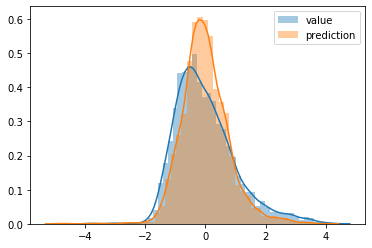

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_norm,Y_train_norm)

Y_pred_lr = lr.predict(X_test_norm)

sns.distplot(Y_test_norm.values,label='value')
sns.distplot(Y_pred_lr,label='prediction')
plt.legend()
score_lr = r2_score(Y_pred_lr,Y_test_norm)
print("The R2 score achieved using Linear Regression is: "+str(round(score_lr,3)))

Elastic Net

The R2 score achieved using Elastic Net Regression is: 0.535


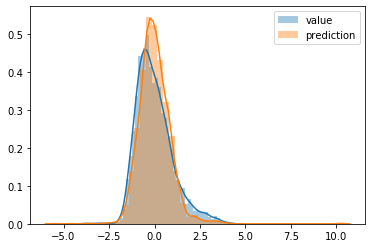

In [20]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(cv=16, random_state = 0)

enet.fit(X_train,np.ravel(Y_train_norm))

Y_pred_enet = enet.predict(X_test)

sns.distplot(Y_test_norm.values,label='value')
sns.distplot(Y_pred_enet,label='prediction')
plt.legend()
score_enet = r2_score(Y_pred_enet,Y_test_norm)
print("The R2 score achieved using Elastic Net Regression is: "+str(round(score_enet,3)))

Nearest Neighbors regression

The R2 score achieved using NN Regression is: 0.727


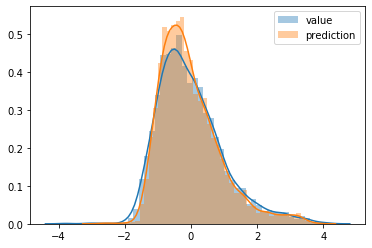

In [21]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train_norm,Y_train_norm)

Y_pred_neigh = neigh.predict(X_test_norm)

sns.distplot(Y_test_norm.values,label='value')
sns.distplot(Y_pred_neigh,label='prediction')
plt.legend()
score_neigh = r2_score(Y_pred_neigh,Y_test_norm)
print("The R2 score achieved using NN Regression is: "+str(round(score_neigh,3)))

Decision Tree

The R2 score achieved using Decision Tree Regression is: 0.657


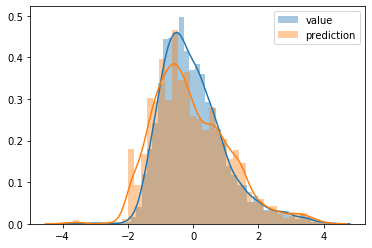

In [22]:
from sklearn import tree
decTree = tree.DecisionTreeRegressor()
decTree = decTree.fit(X_train_norm,Y_train_norm)

Y_pred_tree = decTree.predict(X_test_norm)

sns.distplot(Y_test_norm.values,label='value')
sns.distplot(Y_pred_tree,label='prediction')
plt.legend()
score_tree = r2_score(Y_pred_tree,Y_test_norm)
print("The R2 score achieved using Decision Tree Regression is: "+str(round(score_tree,3)))

Random Forest

The R2 score achieved using Random Forest Regression is: 0.782


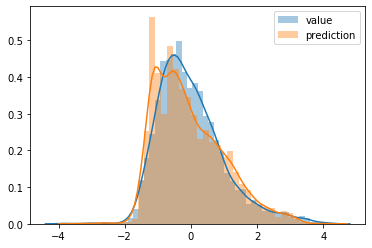

In [23]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
forest.fit(X_train_norm,np.ravel(Y_train_norm))

Y_pred_forest = forest.predict(X_test_norm)

sns.distplot(Y_test_norm.values,label='value')
sns.distplot(Y_pred_forest,label='prediction')
plt.legend()
score_forest = r2_score(Y_pred_forest,Y_test_norm)
print("The R2 score achieved using Random Forest Regression is: "+str(round(score_forest,3)))

Support Vector Machine

The R2 score achieved using SVM Regression is: 0.775


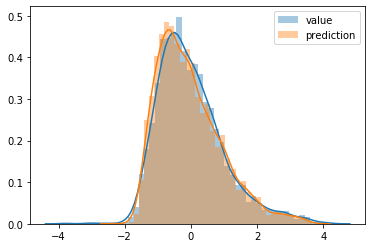

In [24]:
from sklearn import svm
svmreg = svm.SVR()
svmreg.fit(X_train_norm,np.ravel(Y_train_norm))

Y_pred_svm = svmreg.predict(X_test_norm)

sns.distplot(Y_test_norm, label = 'value')
sns.distplot(Y_pred_svm,label = 'prediction')
plt.legend()
score_svm = r2_score(Y_pred_svm,Y_test_norm)
print("The R2 score achieved using SVM Regression is: "+str(round(score_svm,3)))

Neural Network

Using TensorFlow backend.


Epoch 1/100
18090/18090 [==============================] - 0s 14us/step - loss: 0.6634
Epoch 2/100
18090/18090 [==============================] - 0s 9us/step - loss: 0.3106
Epoch 3/100
18090/18090 [==============================] - 0s 9us/step - loss: 0.2453
Epoch 4/100
18090/18090 [==============================] - 0s 9us/step - loss: 0.2243
Epoch 5/100
18090/18090 [==============================] - 0s 9us/step - loss: 0.2134
Epoch 6/100
18090/18090 [==============================] - 0s 11us/step - loss: 0.2062
Epoch 7/100
18090/18090 [==============================] - 0s 10us/step - loss: 0.2019
Epoch 8/100
18090/18090 [==============================] - 0s 9us/step - loss: 0.2047
Epoch 9/100
18090/18090 [==============================] - 0s 9us/step - loss: 0.1973
Epoch 10/100
18090/18090 [==============================] - 0s 15us/step - loss: 0.1938
Epoch 11/100
18090/18090 [==============================] - 0s 19us/step - loss: 0.1926
Epoch 12/100
18090/18090 [=====================

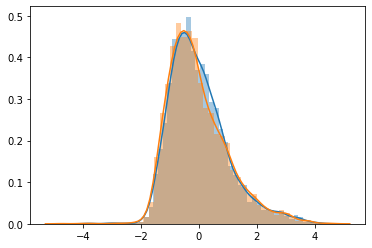

In [25]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


### Defining the model
model = Sequential()
model.add(Dense(24,activation='relu',input_dim=X_train_norm.shape[1]))
model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam')

### Training

model.fit(X_train_norm,Y_train_norm,epochs=100,batch_size=128)

### Testing

Y_pred_nn = model.predict(X_test_norm)

### Evaluating
sns.distplot(Y_test_norm, label = 'value')
sns.distplot(Y_pred_nn,label = 'prediction')

score_nn = round(r2_score(Y_pred_nn[:,0],Y_test_norm),3)

print("The R2 score achieved using this Neural Network is: "+str(score_nn))

XGBoost

The R2 score achieved using XGBoost is: 0.799


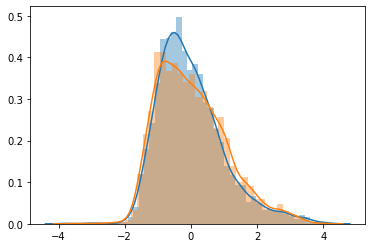

In [26]:
import xgboost as xgb 

xgReg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, 
                         learning_rate = 0.08 ,
                max_depth = 4, n_estimators = 500)

xgReg.fit(X_train_norm,Y_train_norm)

Y_pred_xgb = xgReg.predict(X_test_norm)


sns.distplot(Y_test_norm, label = 'value')
sns.distplot(Y_pred_xgb,label = 'prediction')

score_xgb = round(r2_score(Y_pred_xgb,Y_test_norm),3)

print("The R2 score achieved using XGBoost is: "+str(score_xgb))

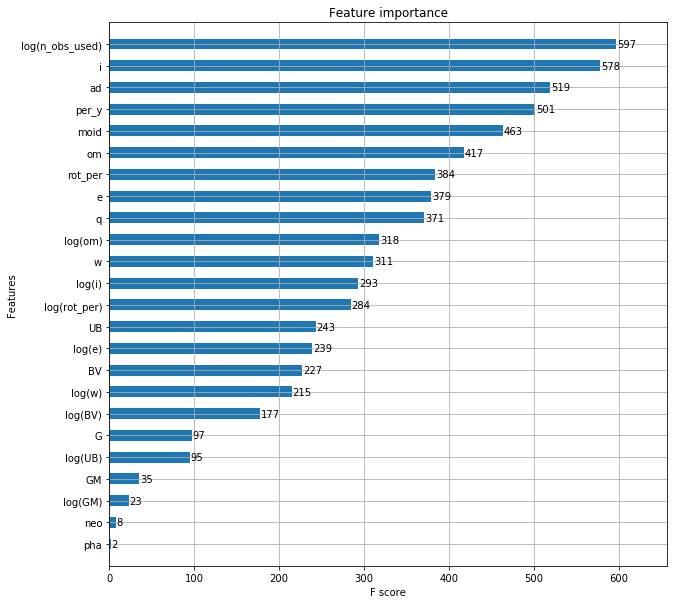

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgReg, height=0.5, ax=ax, importance_type='weight')
plt.show()

Neural Network wins today by a very small margin

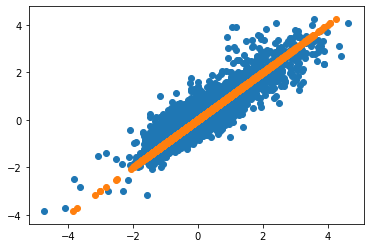

In [28]:
#Scatter plot of prediction vs true value
plt.scatter(Y_pred_nn,Y_test_norm)
plt.scatter(Y_test_norm,Y_test_norm)

Thank you for reading !